# Comparison of different Baseline implementations

(I have access to the crab data sample downloaded with Etiennes script, so this document is based on this data sample)

The digicam emits with every single event a `digicam_baseline(n_pixel)` in addition to the normal `adc_samples(n_pixel, n_sample)`. But in the beginning this `digicam_baseline` was not available. So (I assume) in an attempt to patch this problem, the baseline was estimated from so called "interleaved pedestal events", these are events which are not triggered by the physics trigger, but simply by a clock. The frequency of these interleaved pedestal events is 20Hz.
I do not know what "was not available" exactly means, if (in the beginning) the `digicam_baseline` was not written into the fits file or if it was inside but not possible to read out. 

However ... I had a look at the data sample I have access to, and in all of these files, the `digicam_baseline` is available. I have no idea if *at the moment* Digicam data exists, where the problem of the unavailable `digicam_baseline` persists. If such data exists, I wonder if the SST1M collaboration wants to discard this data as broken, or if it should be kept.

Out of pure curiosity I wanted to understand if the "baseline from interleaved pedestal events"(`pedestal_baseline`) and the `digicam_baseline` are compatible. I found an interesting pattern in the camera, which might be of interest for others as well, so ... if you are interested ... read on.
But altogether I cannot really see a significant difference between the two baseline implementations

In [1]:
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from digicampipe.io.event_stream import event_stream
from digicampipe.calib.camera.random_triggers import fill_baseline_r0
from digicampipe.visualization.mpl import CameraDisplay
from digicampipe.utils import DigiCam

/home/dneise/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
Sleeping = np.array([
       1085, 1117, 1118, 1119, 1120, 1146, 1147, 1148, 1149, 1150, 1151,
       1152, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181,
       1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206,
       1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1239, 1240, 1241,
       1242, 1243, 1256, 1257])
Dead = np.array([ 896,  930,  931,  932,  966,  967,  968, 1002, 1003, 1004, 1038,
       1039])
Broken = np.concatenate((Sleeping, Dead))

In [4]:
def camera(data, cbar_label='LSB', **kwargs):
    d = CameraDisplay(geometry=DigiCam.geometry, **kwargs)
    d.image = data
    cbar = plt.colorbar(d.pixels, ax=d.axes)
    cbar.set_label(cbar_label)
    return d

In [5]:
def get_baselines_and_time_from_file(path):
    ''' takes typically ~25sec for a run-file with ~12500 events
    '''
    digicam_baseline = []
    pedestal_baseline = []
    T = []
    stream = event_stream(path)
    stream = fill_baseline_r0(stream, n_bins=1050) # <--- n_bins=1050 from nsb_evaluation.py default of 10k ... 
    for event in stream:
        for r0 in event.r0.tel.values():
            digicam_baseline.append(r0.digicam_baseline)
            pedestal_baseline.append(r0.baseline)
            T.append(r0.local_camera_clock)

    pedestal_baseline = np.array(pedestal_baseline)
    digicam_baseline = np.array(digicam_baseline)
    T = pd.to_datetime(T, unit='ns')

    # At run-start we have not enough statistics, so at the beginning there is sometimes no pedestal_baseline
    # So we drop that
    missing_data = np.isnan(pedestal_baseline).any(axis=1)
    pedestal_baseline = pedestal_baseline[~missing_data]
    digicam_baseline = digicam_baseline[~missing_data]
    T = T[~missing_data]

    # digicam_baseline is an integer, pedestal_baseline is a float. For easier comparision I 
    # round pedestal_baseline to the next integer
    pedestal_baseline = pedestal_baseline.round().astype(np.int16)

    digicam_baseline[:, Broken] = 0
    pedestal_baseline[:, Broken] = 0
    
    return digicam_baseline, pedestal_baseline, T

In [6]:
paths = sorted(glob('../data/*.fits.fz'))
example_path = paths[-1]
example_path

'../data/SST1M01_20171030.091.fits.fz'

In [7]:
%time D, P, T = get_baselines_and_time_from_file(example_path)

CPU times: user 22.5 s, sys: 347 ms, total: 22.9 s
Wall time: 22.9 s


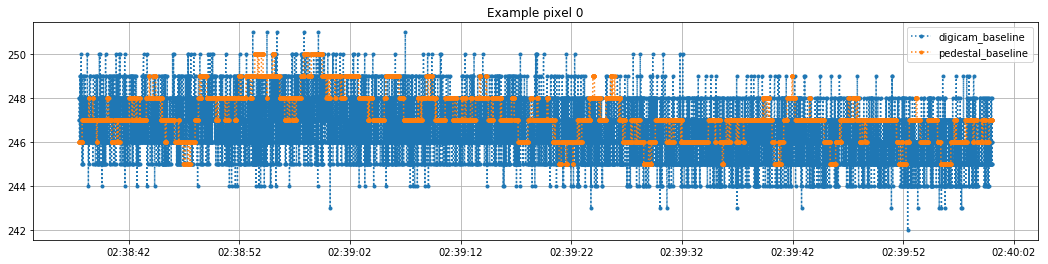

In [8]:
plt.figure(figsize=(18, 4))
plt.plot(T, D[:,0], '.:', label='digicam_baseline');
plt.plot(T, P[:,0], '.:', label='pedestal_baseline');
plt.title('Example pixel 0');
plt.legend()
plt.grid()


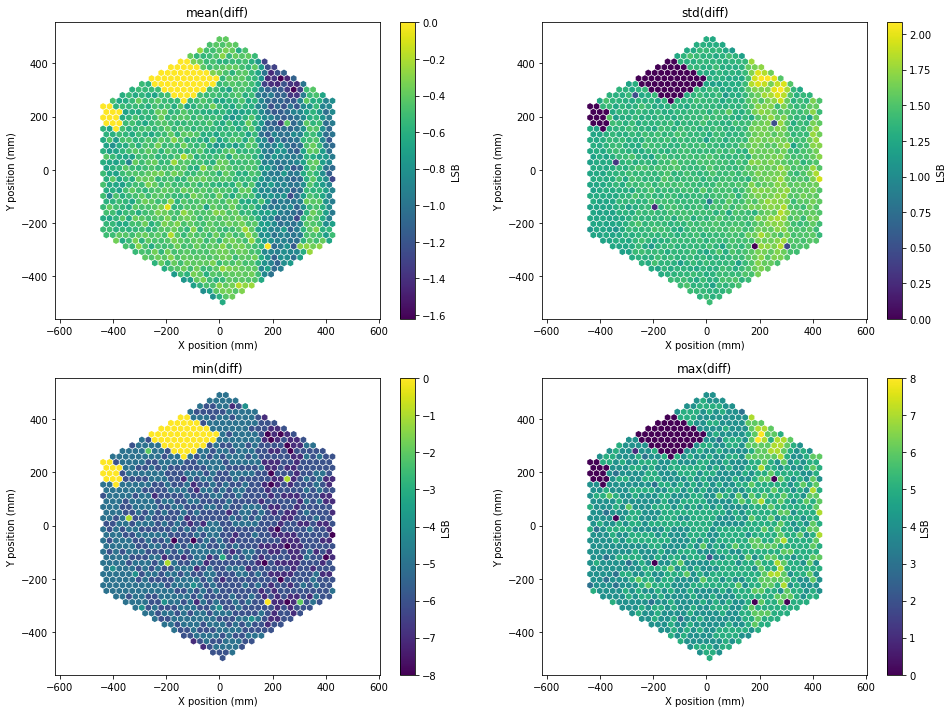

In [9]:
diff = D - P
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

camera(diff.mean(axis=0), ax=ax[0, 0], title='mean(diff)')
camera(diff.std(axis=0), ax=ax[0, 1], title='std(diff)')
camera(diff.min(axis=0), ax=ax[1, 0], title='min(diff)')
camera(diff.max(axis=0), ax=ax[1, 1], title='max(diff)');

We see the mean difference is less than -1LSB. Ignoring the known broken pixels, we see a vertical bar in the camera where the two different baseline implementations do not agree very well. Let us have a look at the individual baselines, just to see, if we can see any hint for this vertical bar in any of them.

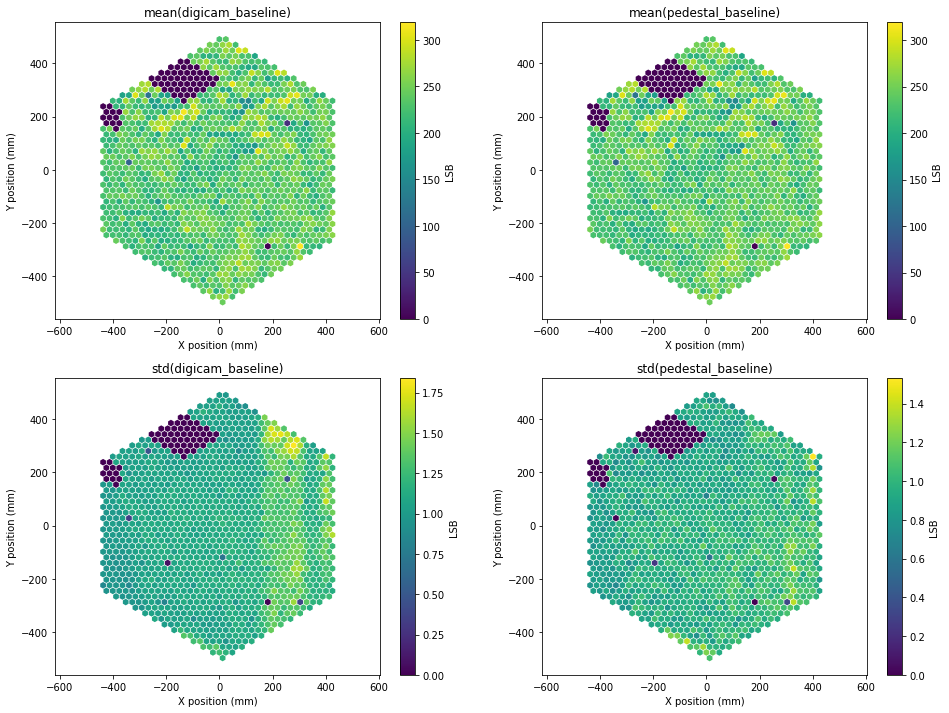

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

camera(D.mean(axis=0), ax=ax[0, 0], title='mean(digicam_baseline)')
camera(P.mean(axis=0), ax=ax[0, 1], title='mean(pedestal_baseline)')
camera(D.std(axis=0), ax=ax[1, 0], title='std(digicam_baseline)')
camera(P.std(axis=0), ax=ax[1, 1], title='std(pedestal_baseline)');

Indeed the the width of the digicam baseline shows the same stripe. One would expect an elevated noise in the baseline, in case there was some kind of additional illumination, but there seems to be nothing visible in the average baseline in that part of the camera.

Let us look at another run for comparison.

Using run: ../data/SST1M01_20171030.035.fits.fz


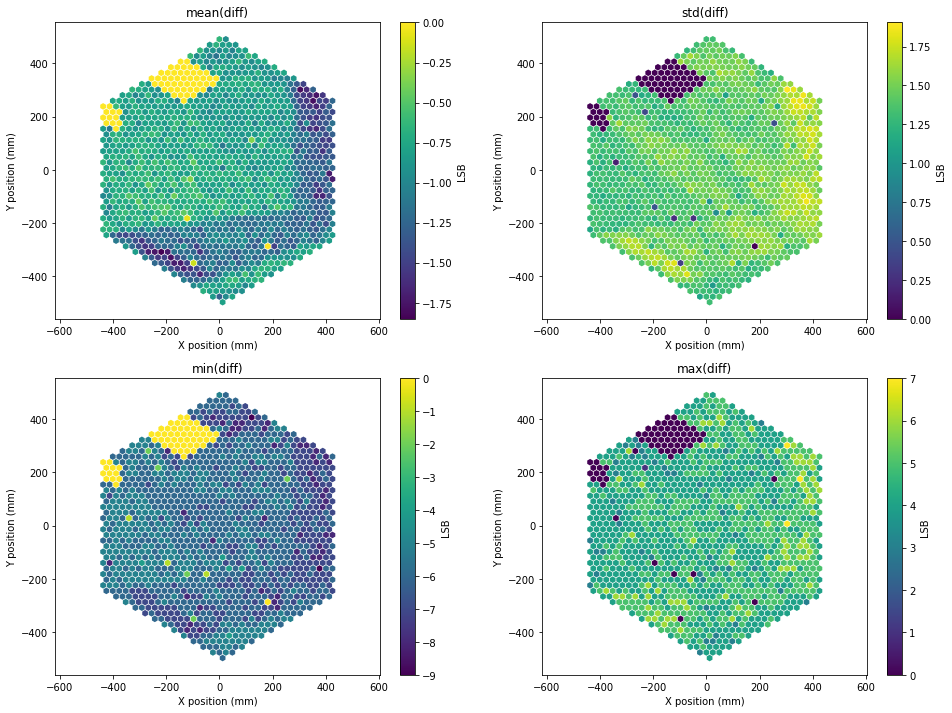

In [11]:
path = paths[35]
print('Using run:', path)
D, P, T = get_baselines_and_time_from_file(path)

diff = D - P
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

camera(diff.mean(axis=0), ax=ax[0, 0], title='mean(diff)')
camera(diff.std(axis=0), ax=ax[0, 1], title='std(diff)')
camera(diff.min(axis=0), ax=ax[1, 0], title='min(diff)')
camera(diff.max(axis=0), ax=ax[1, 1], title='max(diff)');

We see a very similar vertical bar or stripe in the camera. Maybe a shadow from the structure... It looks different now. If it was a shadow, then this could be explained by a movement of the camera or by the light source or both.

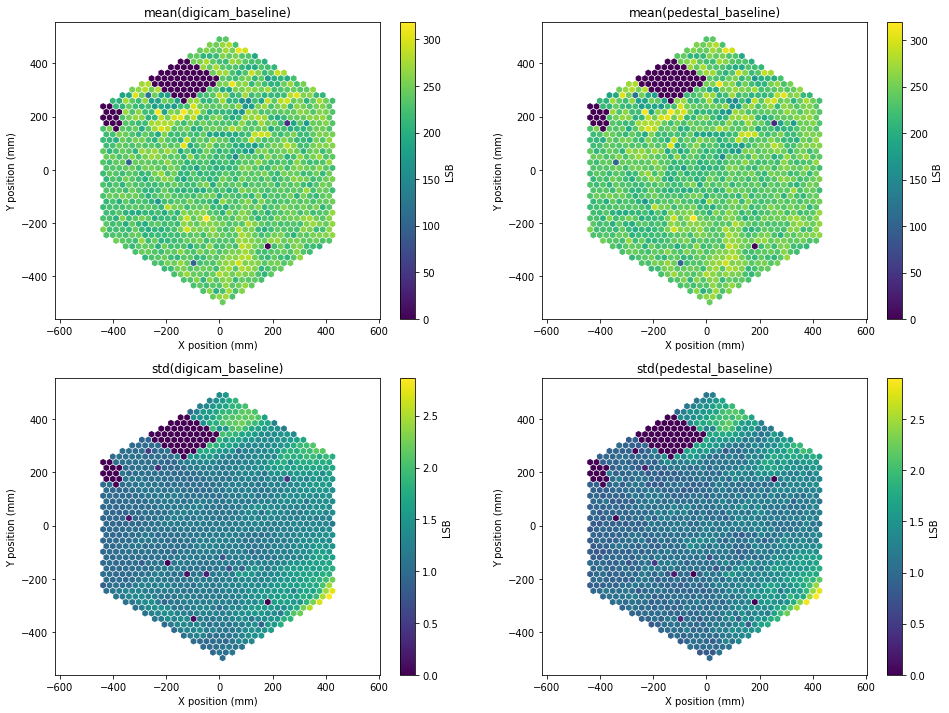

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

camera(D.mean(axis=0), ax=ax[0, 0], title='mean(digicam_baseline)')
camera(P.mean(axis=0), ax=ax[0, 1], title='mean(pedestal_baseline)')
camera(D.std(axis=0), ax=ax[1, 0], title='std(digicam_baseline)')
camera(P.std(axis=0), ax=ax[1, 1], title='std(pedestal_baseline)');

This time we cannot really see the same structure in the individual baselines. 